In [14]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
import quantstats as qs
# import gym_anytrading

import sys
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading")
import importlib
%load_ext autoreload
%autoreload 2
from envs import MyForexEnv, Actions
# sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/")
# from datasets import FOREX_EURUSD_RENKO
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
name = 'FOREX_EURUSD_RENKO'
# base_dir = os.path.dirname(os.path.abspath(__file__))
path = "C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading/datasets/data/renko_full_data_81.csv"
# path = os.path.join(base_dir, '.csv')
FOREX_EURUSD_RENKO = pd.read_csv(path, parse_dates=True, index_col='datetime')

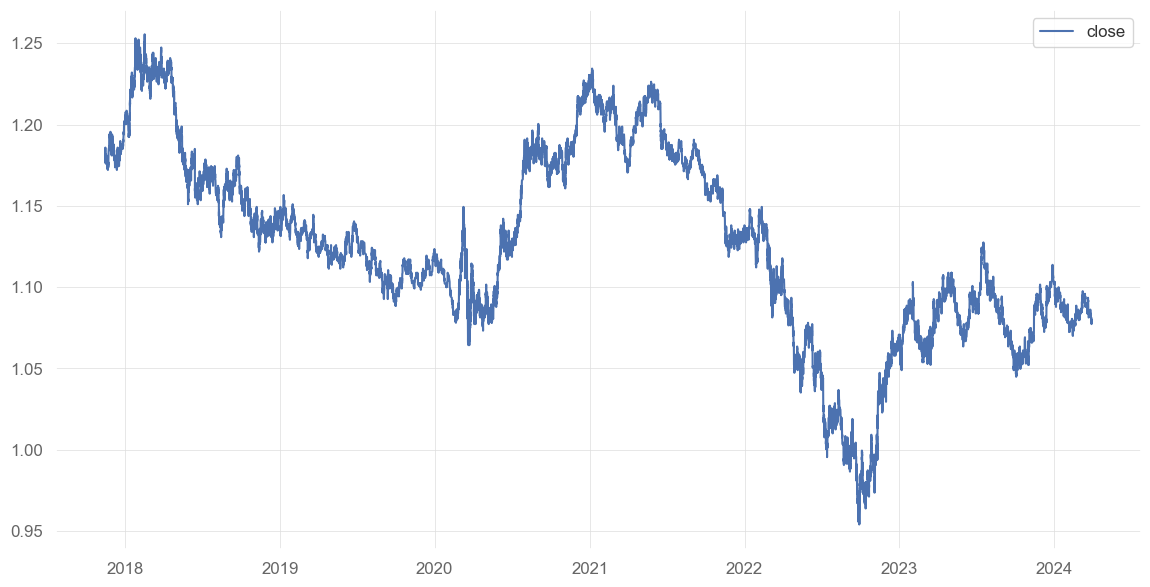

In [16]:
# plot the close price over time
plt.figure(figsize=(14, 7))
plt.plot(FOREX_EURUSD_RENKO.close, label='close')
plt.legend()
plt.show()


In [17]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [ ]:
# find the max date for FOREX_EURUSD_RENKO
max_date = FOREX_EURUSD_RENKO.index.max()
# get the month of the max date
max_date_month = max_date.month
second_to_last_month = max_date_month - 1
# find the row index for the last day of the second to last month
second_to_last_month_day = FOREX_EURUSD_RENKO[FOREX_EURUSD_RENKO.index.month == second_to_last_month].index.max()
split = FOREX_EURUSD_RENKO.loc[:second_to_last_month_day].shape[0]

In [18]:
env_train = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(10, int(split)),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=False,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)
print(int(len(FOREX_EURUSD_RENKO)*.8))

25923


In [19]:
seed_ppo = 42  # random seed
obs_ppo, info_ppo = env_train.reset(seed=seed_ppo)
torch.manual_seed(seed_ppo)
random.seed(seed_ppo)
np.random.seed(seed_ppo)

vec_env_ppo = None

total_learning_timesteps_ppo = 5000 * 1000 # 5000
policy_dict_ppo = PPO.policy_aliases
policy_ppo = policy_dict_ppo.get('MlpPolicy')
if policy_ppo is None:
    policy_ppo = policy_dict_ppo.get('MlpLstmPolicy')

model_ppo = PPO(policy_ppo, env_train, verbose=0)

print(f'model {type(model_ppo)}')
print(f'policy {type(model_ppo.policy)}')

# custom callback for 'progress_bar'
model_ppo.learn(total_timesteps=total_learning_timesteps_ppo, callback=ProgressBarCallback(100))

env_train.close()

model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 5001200it [3:04:03, 452.87it/s]                               


In [20]:
env_test = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(int(split), int(len(FOREX_EURUSD_RENKO))),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=False,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)

In [21]:
done = False
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info_ppo = env_test.reset(seed=seed_ppo)

while not done:
    action_ppo, _states = model_ppo.predict(obs_ppo)
    action_stats[Actions(action_ppo)] += 1
    obs_ppo, reward_ppo, terminated, truncated, info_ppo = env_test.step(action_ppo)
    done = terminated or truncated

    if done:
        break

env_test.close()

print("action_stats:", action_stats)
print("info:", info_ppo)

action_stats: {<Actions.Sell: 0>: 5460, <Actions.Buy: 1>: 695}
info: {'total_reward': -485.9638214111328, 'total_profit': 0.950786080874304, 'position': <Positions.Short: 0>}


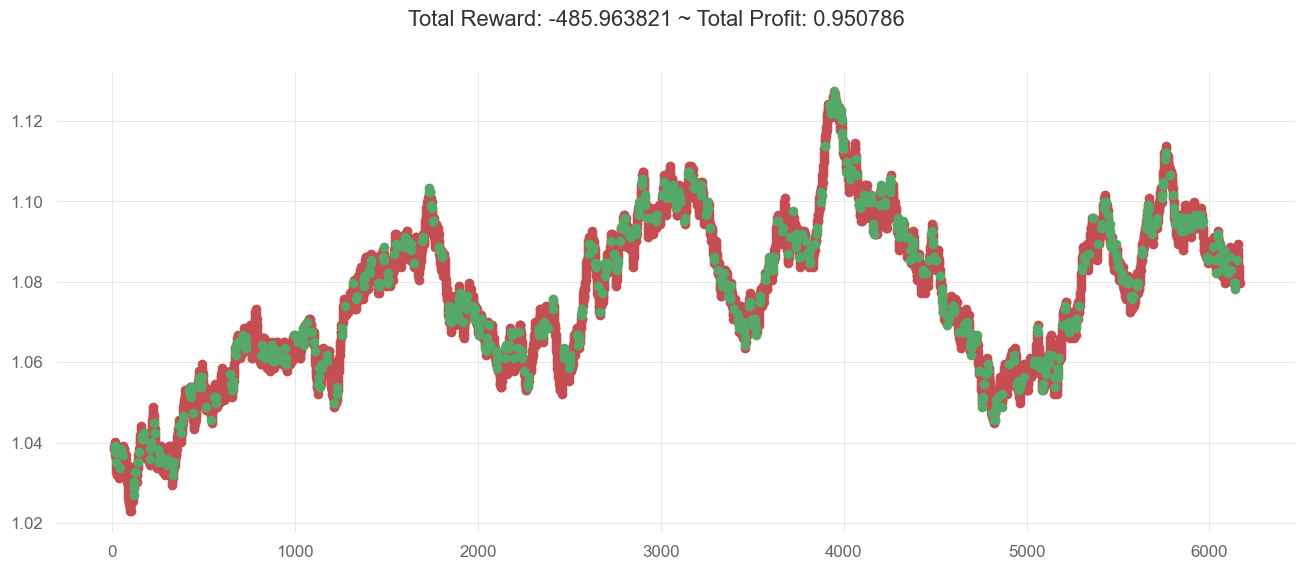

In [22]:
plt.figure(figsize=(16, 6))
env_test.unwrapped.render_all()
plt.show()

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and retu

                           Strategy
-------------------------  ----------
Start Period               2022-11-17
End Period                 2024-02-02
Risk-Free Rate             0.0%
Time in Market             9.0%

Cumulative Return          -4.92%
CAGR﹪                     -2.84%

Sharpe                     -0.36
Prob. Sharpe Ratio         3.63%
Smart Sharpe               -0.36
Sortino                    -0.47
Smart Sortino              -0.47
Sortino/√2                 -0.33
Smart Sortino/√2           -0.33
Omega                      0.84

Max Drawdown               -7.14%
Longest DD Days            372
Volatility (ann.)          0.57%
Calmar                     -0.4
Skew                       -0.91
Kurtosis                   20.04

Expected Daily %           -0.0%
Expected Monthly %         -0.31%
Expected Yearly %          -1.67%
Kelly Criterion            -9.28%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.06%
Expected Shortfall (cVaR)  -0.06%

Max Consecutive Wins

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-01-27,2023-10-25,2024-02-02,372,-7.141670,-6.891430
2,2022-12-22,2023-01-03,2023-01-09,18,-0.804270,-0.737486
3,2022-12-12,2022-12-13,2022-12-16,4,-0.618768,-0.552520
4,2022-12-01,2022-12-05,2022-12-07,7,-0.402973,-0.278840
5,2022-11-17,2022-11-28,2022-11-29,12,-0.396523,-0.299607


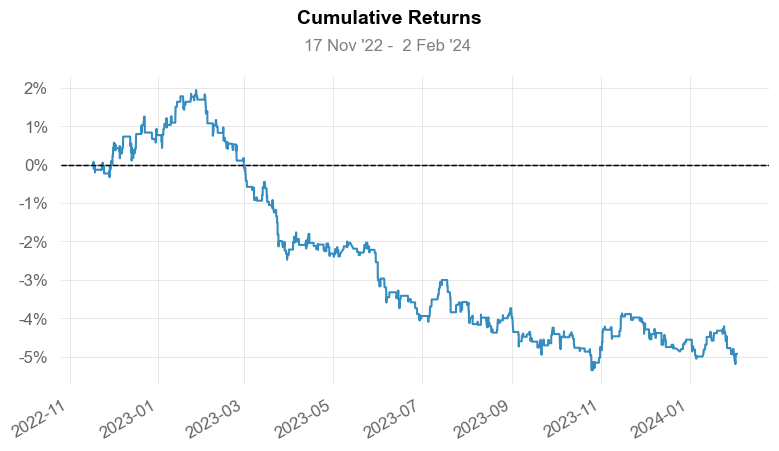

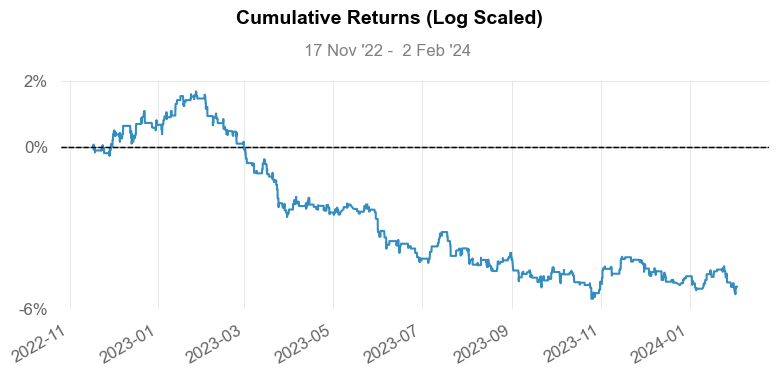

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


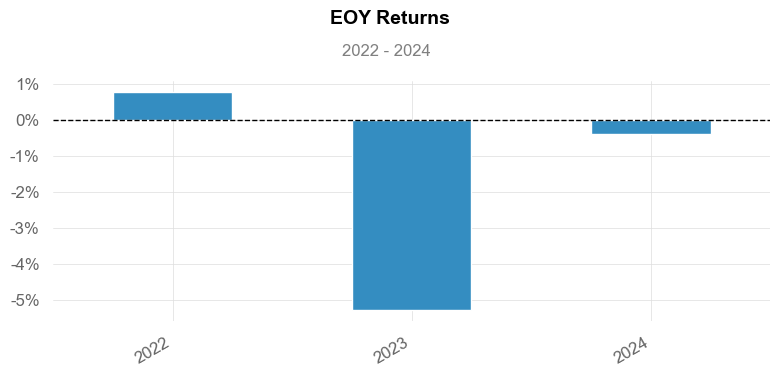

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


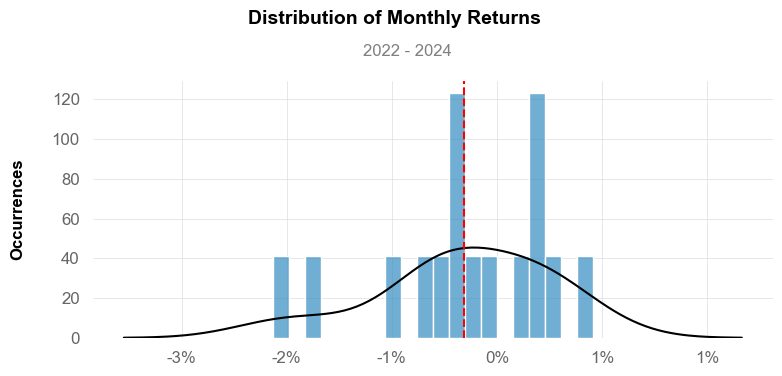

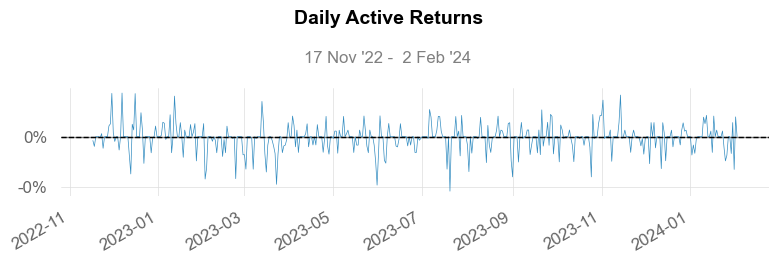

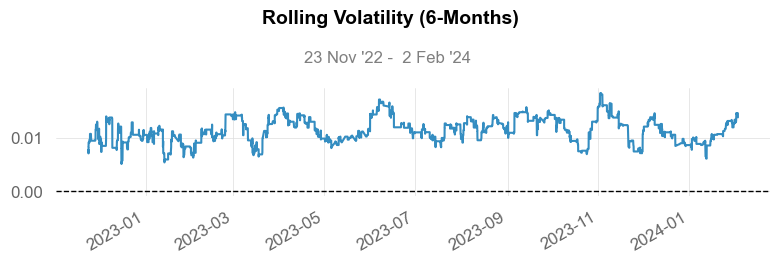

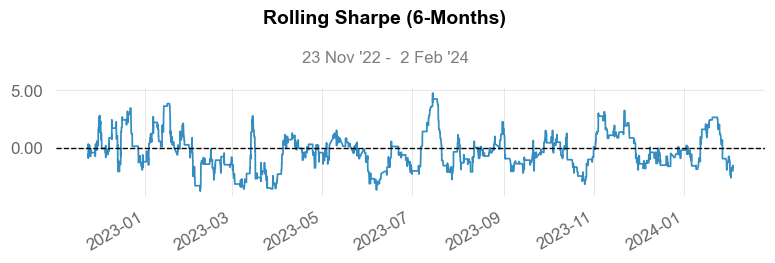

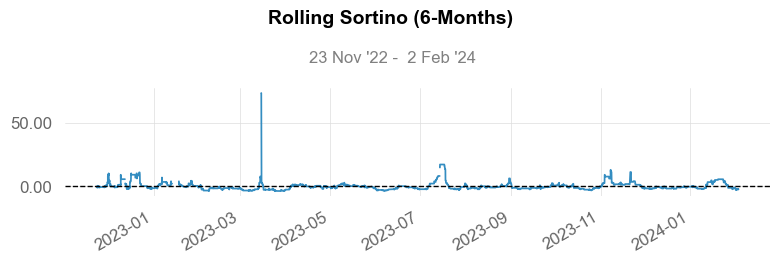

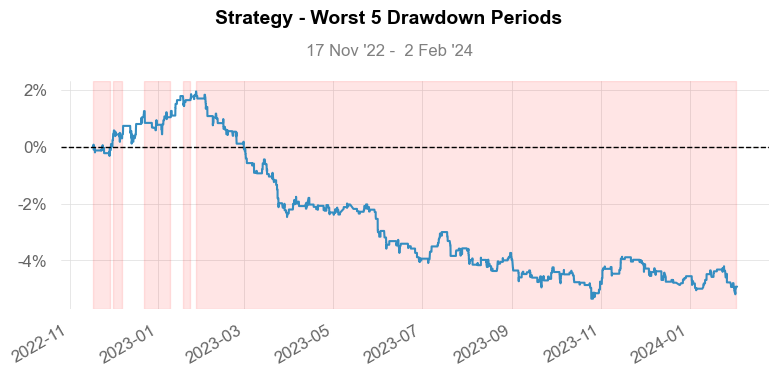

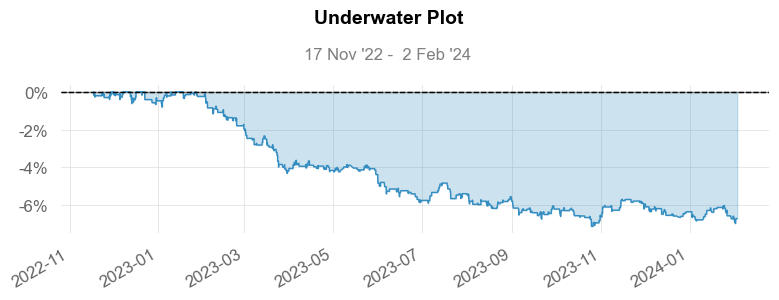

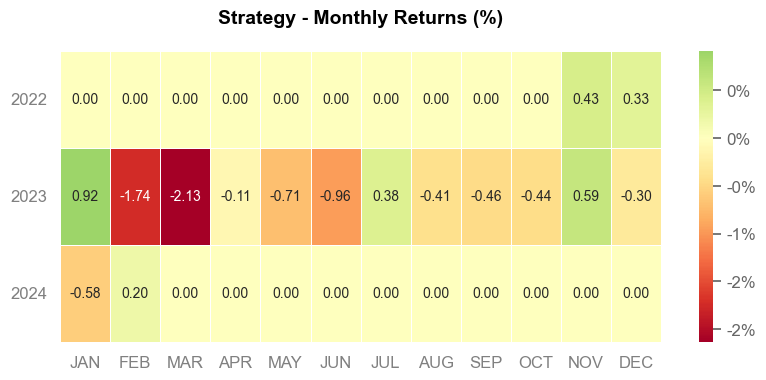

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python

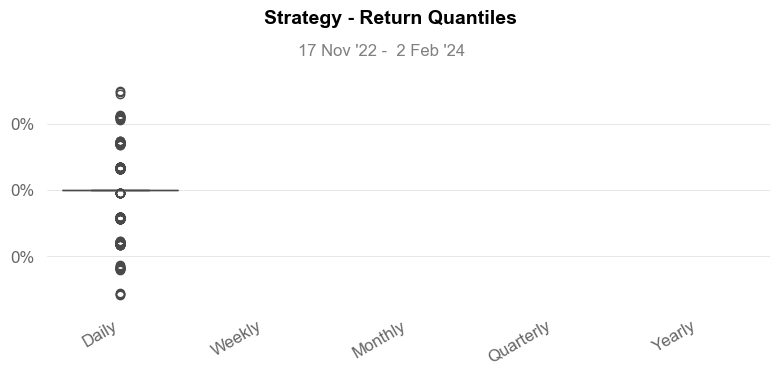

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and retu

In [23]:
qs.extend_pandas()
window_size = 10
start_index = int(split)
end_index = int(len(FOREX_EURUSD_RENKO))

net_worth = pd.Series(env_test.unwrapped.history['total_profit'], index=FOREX_EURUSD_RENKO.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats_ppo_Billy.html')